In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src directory to path
sys.path.append('../src')

# Import custom modules
from data_processing import load_csv_numpy, check_missing_values, feature_statistics
from data_processing import correlation_matrix, compute_skewness, compute_kurtosis
from visualization import plot_class_distribution, plot_correlation_matrix
from visualization import plot_fraud_vs_legit_feature, plot_time_distribution, plot_amount_distribution

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

NumPy version: 2.2.4
Matplotlib version: 3.10.1
Seaborn version: 0.13.2


# Credit Card Fraud Detection - Data Exploration

## Research Questions

### 1. What can we learn about fraudulent and legitimate transactions?
- What is the fraud rate in the dataset?
- What distinguishes fraudulent transactions from legitimate ones?
- Are feature distributions different between the two transaction types?

### 2. Are there notable differences in time and transaction amounts?
- When do fraudulent transactions typically occur?
- Do fraudulent transactions have different amounts compared to legitimate ones?
- Is there any correlation between Time, Amount, and Class?

### 3. Which features are strongly correlated with fraud?
- Which features (V1-V28) have high correlation with Class?
- Are there any patterns in the correlation matrix?

### 4. What data quality issues need to be addressed?
- Are there any missing values?
- Are there outliers? And are they fraud patterns?
- Does the data need normalization/standardization?

---

## 1. Data Loading

Load the credit card fraud detection dataset using pure NumPy.

In [2]:
# Load data
data_path = '../data/raw/creditcard.csv'

if os.path.exists(data_path):
    print("Loading dataset...")
    data = load_csv_numpy(data_path)
    print(f"\nData shape: {data.shape}")
    print(f"Number of transactions: {data.shape[0]:,}")
    print(f"Number of features: {data.shape[1]}")
else:
    print(f"ERROR: Dataset not found at {data_path}")
    print("Please download the dataset from:")
    print("https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data")
    print("And place it in the data/raw/ directory")

Loading dataset...
Data loaded successfully: (284807, 31)

Data shape: (284807, 31)
Number of transactions: 284,807
Number of features: 31


## 2. Basic Data Inspection

In [3]:
# Separate features and target
X = data[:, :-1]  # All columns except last
y = data[:, -1]   # Last column (Class)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)
print("\nFirst 5 rows of features:")
print(X[:5, :5])  # Show first 5 rows, first 5 columns
print("\nFirst 10 target values:")
print(y[:10])

# DEBUG: Check if target column has any fraud cases
print("\n" + "=" * 50)
print("DEBUG: Checking target distribution")
print("=" * 50)
print(f"Unique values in target: {np.unique(y)}")
print(f"Min value: {y.min()}, Max value: {y.max()}")
print(f"Sum of target (fraud count): {int(y.sum())}")
print(f"\nLast 5 columns of first 10 rows (to check column order):")
print(data[:10, -5:])
print("\nColumn names from CSV should be:")
print("Time, V1-V28, Amount, Class")
print("Total: 31 columns (but we loaded 30 features + 1 target)")

Feature matrix shape: (284807, 30)
Target vector shape: (284807,)

First 5 rows of features:
[[ 0.         -1.35980713 -0.07278117  2.53634674  1.37815522]
 [ 0.          1.19185711  0.26615071  0.16648011  0.44815408]
 [ 1.         -1.35835406 -1.34016307  1.77320934  0.37977959]
 [ 1.         -0.96627171 -0.18522601  1.79299334 -0.86329128]
 [ 2.         -1.15823309  0.87773675  1.54871785  0.40303393]]

First 10 target values:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

DEBUG: Checking target distribution
Unique values in target: [0. 1.]
Min value: 0.0, Max value: 1.0
Sum of target (fraud count): 492

Last 5 columns of first 10 rows (to check column order):
[[-1.89114844e-01  1.33558377e-01 -2.10530535e-02  1.49620000e+02
   0.00000000e+00]
 [ 1.25894532e-01 -8.98309914e-03  1.47241692e-02  2.69000000e+00
   0.00000000e+00]
 [-1.39096572e-01 -5.53527940e-02 -5.97518406e-02  3.78660000e+02
   0.00000000e+00]
 [-2.21928844e-01  6.27228487e-02  6.14576285e-02  1.23500000e+02
   0.00000000e+00]
 [

In [4]:
# Check for missing values
print("=" * 50)
print("MISSING VALUE ANALYSIS")
print("=" * 50)
missing_info = check_missing_values(data)

if missing_info['total'] == 0:
    print("\n[PASS] No missing values found in the dataset!")
else:
    print(f"\n[FOUND] {missing_info['total']} missing values")

MISSING VALUE ANALYSIS
Total missing values: 0
Missing percentage: 0.0000%

[PASS] No missing values found in the dataset!


## 3. Class Distribution Analysis

Analyze the distribution of fraud vs legitimate transactions.

In [5]:
# Calculate class distribution
unique_classes, class_counts = np.unique(y, return_counts=True)

print("=" * 50)
print("CLASS DISTRIBUTION")
print("=" * 50)

# Debug: Show what we found
print(f"Unique classes found: {unique_classes}")
print(f"Counts: {class_counts}")
print()

# Check if we have NaN values
if np.isnan(unique_classes).any():
    print("[ERROR] Target column contains NaN values!")
    print("\nThis means the CSV file was not loaded correctly.")
    print("\n[FIX] Restart the kernel and re-run from cell 1")
    print("   The load_csv_numpy function has been updated to fix this issue.")
    print("\nSteps:")
    print("   1. Click 'Restart' button in the toolbar")
    print("   2. Run 'Run All' to execute all cells from the beginning")
elif len(unique_classes) < 2:
    print(f"[WARNING] Only {len(unique_classes)} class found in the dataset!")
    print(f"Class {unique_classes[0]}: {class_counts[0]:,} samples")
    print("\nThis might indicate:")
    print("  1. Data loading issue - check CSV file structure")
    print("  2. Wrong column selected as target")
else:
    # Both classes present - SUCCESS!
    print(f"Legitimate transactions (0): {class_counts[0]:,} ({class_counts[0]/len(y)*100:.4f}%)")
    print(f"Fraudulent transactions (1): {class_counts[1]:,} ({class_counts[1]/len(y)*100:.4f}%)")
    print(f"\nImbalance ratio: 1:{class_counts[0]//class_counts[1]}")
    print(f"\n[WARNING] This is a highly imbalanced dataset!")

CLASS DISTRIBUTION
Unique classes found: [0. 1.]
Counts: [284315    492]

Legitimate transactions (0): 284,315 (99.8273%)
Fraudulent transactions (1): 492 (0.1727%)

Imbalance ratio: 1:577

[WARNING] This is a highly imbalanced dataset!


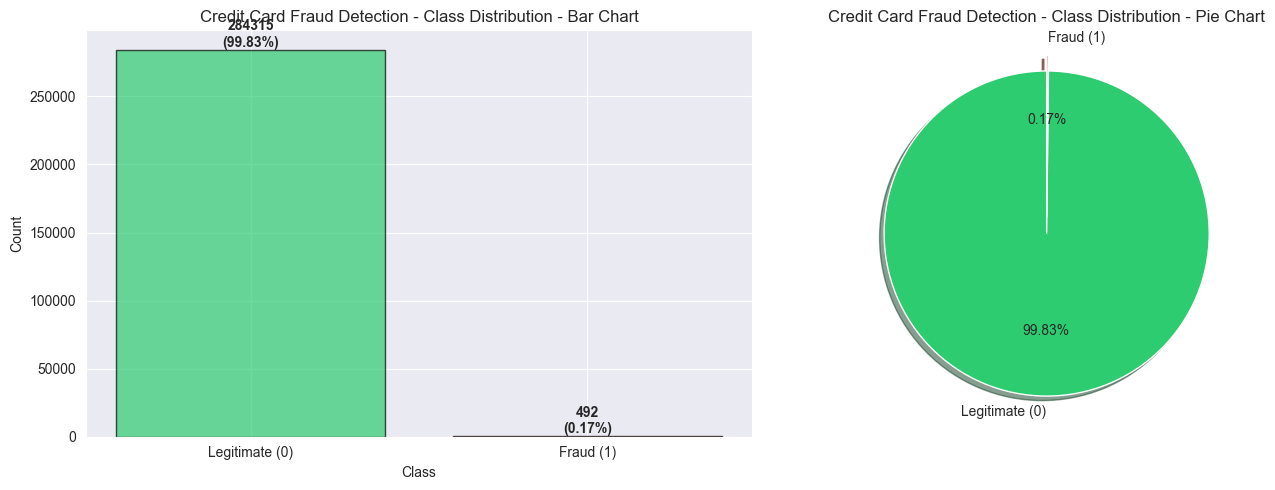

In [6]:
# Visualize class distribution
plot_class_distribution(y, title="Credit Card Fraud Detection - Class Distribution")

## 4. Statistical Summary

Compute descriptive statistics for all features.

In [7]:
# Feature names
feature_names = ['Time'] + [f'V{i}' for i in range(1, 29)] + ['Amount']

# Compute statistics
print("=" * 80)
print("DESCRIPTIVE STATISTICS")
print("=" * 80)
print(f"{'Feature':<10} {'Mean':>12} {'Median':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 80)

for i in range(min(10, X.shape[1])):  # Show first 10 features
    feature_data = X[:, i]
    print(f"{feature_names[i]:<10} {np.mean(feature_data):>12.2f} {np.median(feature_data):>12.2f} "
          f"{np.std(feature_data):>12.2f} {np.min(feature_data):>12.2f} {np.max(feature_data):>12.2f}")

print("\n... (showing first 10 features only)")

DESCRIPTIVE STATISTICS
Feature            Mean       Median          Std          Min          Max
--------------------------------------------------------------------------------
Time           94813.86     84692.00     47488.06         0.00    172792.00
V1                 0.00         0.02         1.96       -56.41         2.45
V2                 0.00         0.07         1.65       -72.72        22.06
V3                -0.00         0.18         1.52       -48.33         9.38
V4                 0.00        -0.02         1.42        -5.68        16.88
V5                 0.00        -0.05         1.38      -113.74        34.80
V6                 0.00        -0.27         1.33       -26.16        73.30
V7                -0.00         0.04         1.24       -43.56       120.59
V8                 0.00         0.02         1.19       -73.22        20.01
V9                -0.00        -0.05         1.10       -13.43        15.59

... (showing first 10 features only)


In [8]:
# Special attention to Time and Amount features
time_idx = 0
amount_idx = -1

print("=" * 50)
print("TIME FEATURE ANALYSIS")
print("=" * 50)
print(f"Min time: {X[:, time_idx].min():.0f} seconds ({X[:, time_idx].min()/3600:.2f} hours)")
print(f"Max time: {X[:, time_idx].max():.0f} seconds ({X[:, time_idx].max()/3600:.2f} hours)")
print(f"Time span: {(X[:, time_idx].max() - X[:, time_idx].min())/3600:.2f} hours")
print(f"           {(X[:, time_idx].max() - X[:, time_idx].min())/(3600*24):.2f} days")

print("\n" + "=" * 50)
print("AMOUNT FEATURE ANALYSIS")
print("=" * 50)
print(f"Mean amount: ${X[:, amount_idx].mean():.2f}")
print(f"Median amount: ${np.median(X[:, amount_idx]):.2f}")
print(f"Std amount: ${X[:, amount_idx].std():.2f}")
print(f"Min amount: ${X[:, amount_idx].min():.2f}")
print(f"Max amount: ${X[:, amount_idx].max():.2f}")
print(f"\n25th percentile: ${np.percentile(X[:, amount_idx], 25):.2f}")
print(f"75th percentile: ${np.percentile(X[:, amount_idx], 75):.2f}")
print(f"95th percentile: ${np.percentile(X[:, amount_idx], 95):.2f}")

TIME FEATURE ANALYSIS
Min time: 0 seconds (0.00 hours)
Max time: 172792 seconds (48.00 hours)
Time span: 48.00 hours
           2.00 days

AMOUNT FEATURE ANALYSIS
Mean amount: $88.35
Median amount: $22.00
Std amount: $250.12
Min amount: $0.00
Max amount: $25691.16

25th percentile: $5.60
75th percentile: $77.16
95th percentile: $365.00


## 5. Feature Distribution Analysis

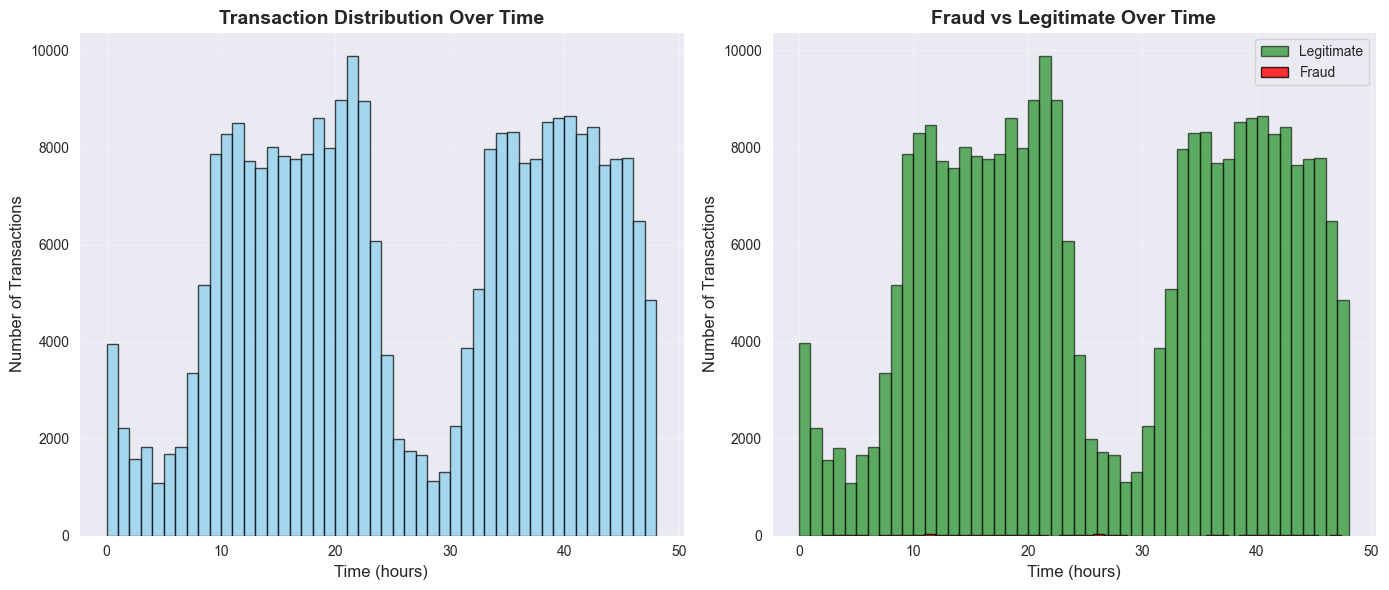

In [9]:
# Plot Time distribution
plot_time_distribution(X[:, time_idx], y)

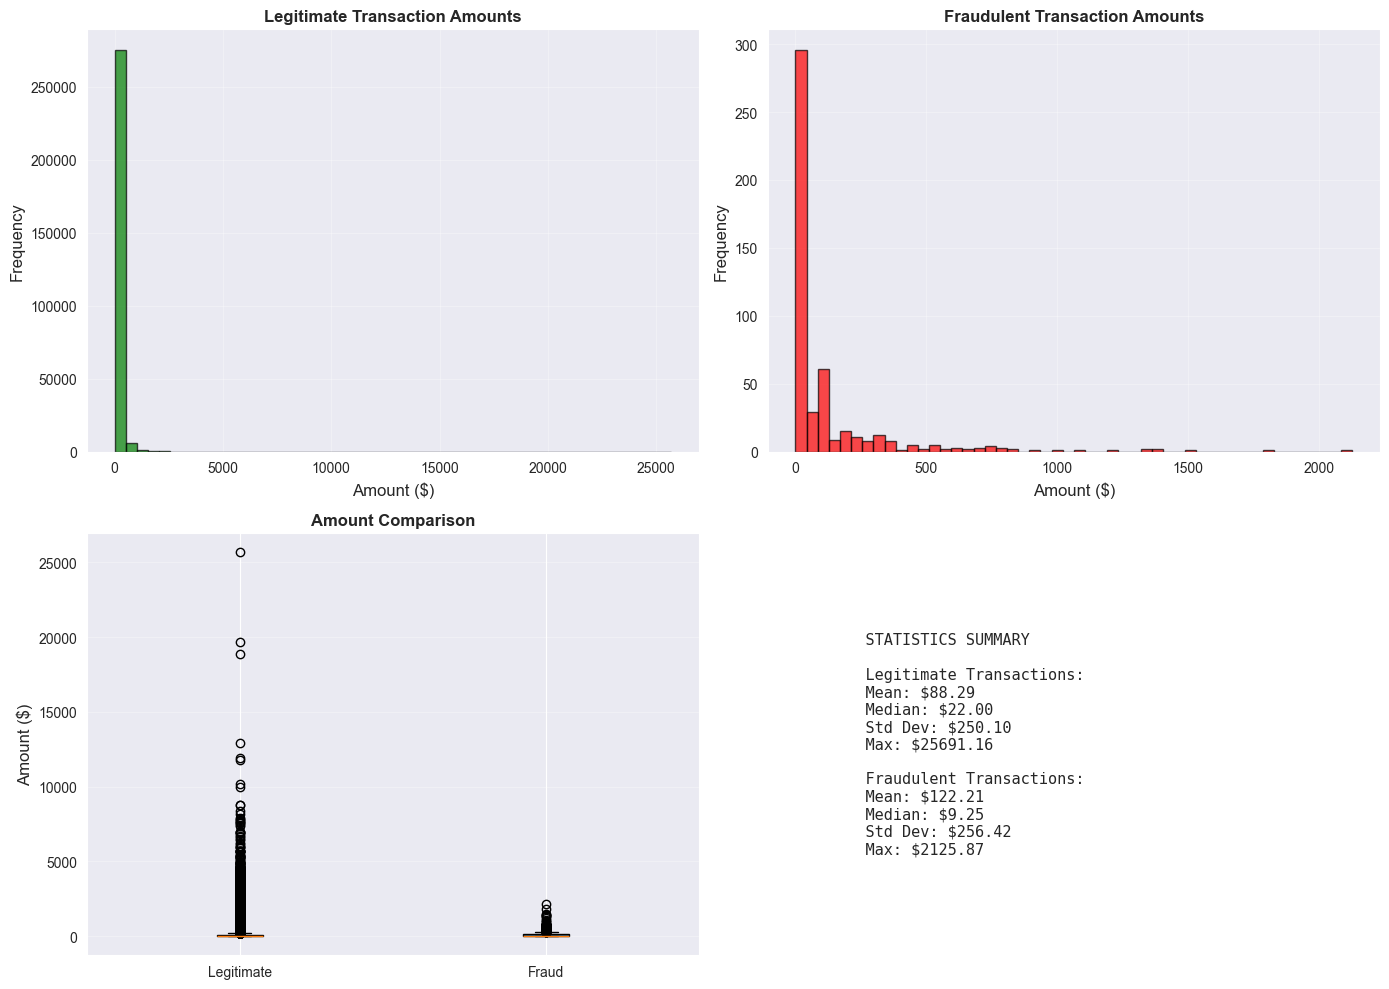

In [10]:
# Plot Amount distribution
plot_amount_distribution(X[:, amount_idx], y)

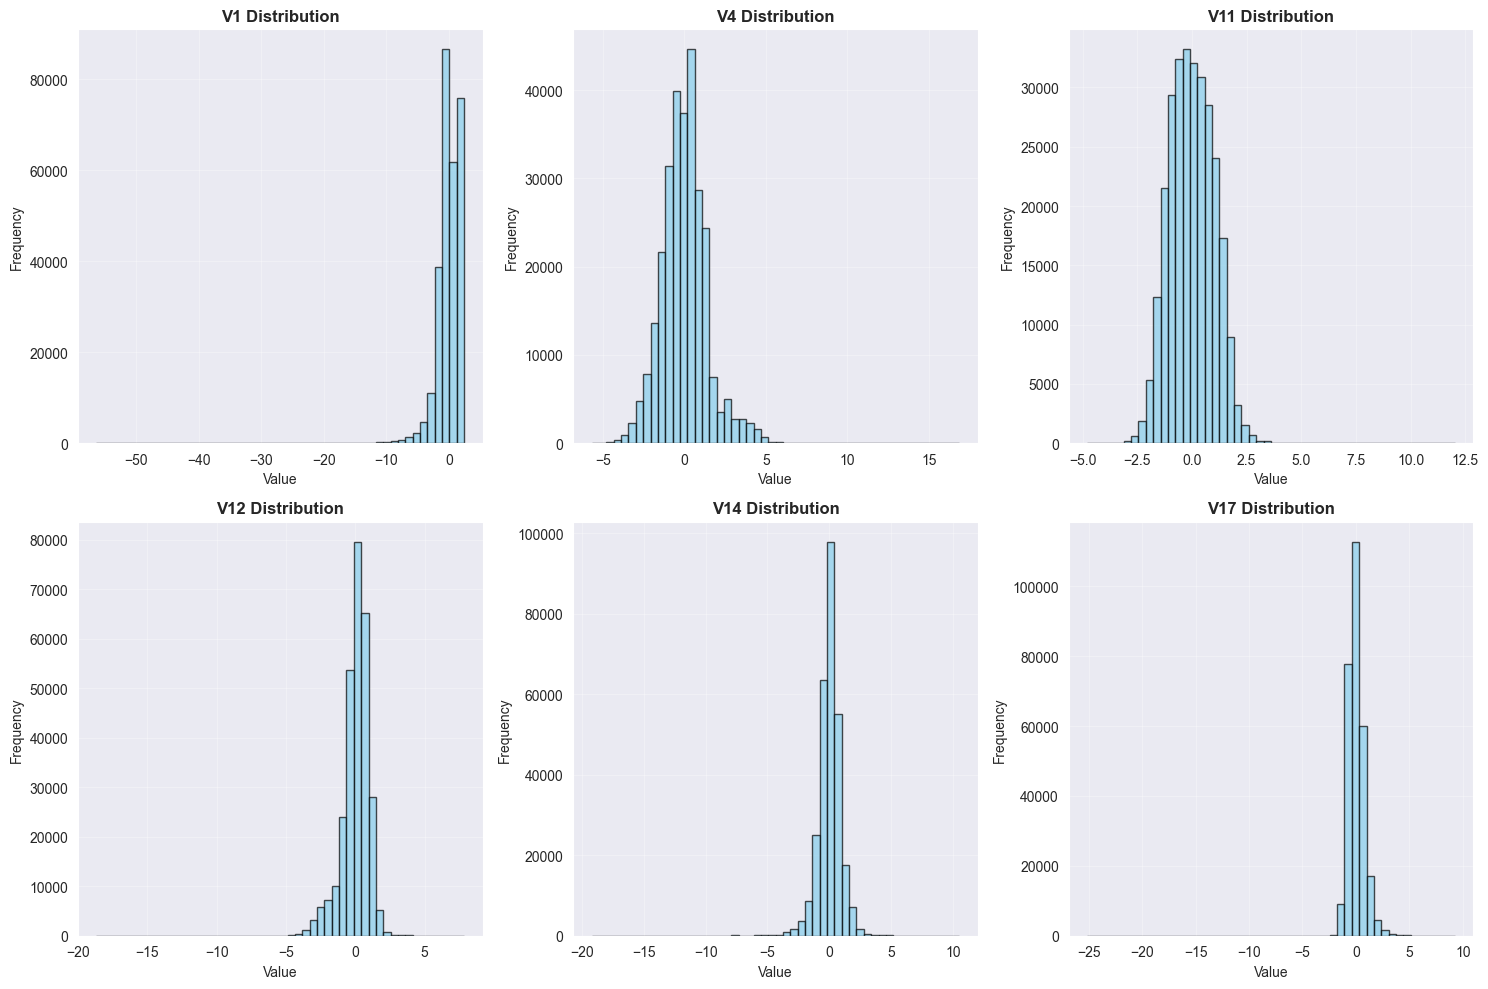

In [11]:
# Plot distributions for some V features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

v_features_to_plot = [1, 4, 11, 12, 14, 17]  # Interesting V features

for i, v_idx in enumerate(v_features_to_plot):
    feature_data = X[:, v_idx]
    axes[i].hist(feature_data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'V{v_idx} Distribution', fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Correlation Analysis

Analyze correlations between features and the target variable.

In [12]:
# Compute correlation with target
correlations = []
for i in range(X.shape[1]):
    # Pearson correlation
    corr = np.corrcoef(X[:, i], y)[0, 1]
    correlations.append(corr)

correlations = np.array(correlations)

# Find features with highest absolute correlation
sorted_indices = np.argsort(np.abs(correlations))[::-1]

print("=" * 60)
print("TOP 15 FEATURES CORRELATED WITH FRAUD")
print("=" * 60)
print(f"{'Rank':<6} {'Feature':<10} {'Correlation':>15}")
print("-" * 60)

for rank, idx in enumerate(sorted_indices[:15], 1):
    print(f"{rank:<6} {feature_names[idx]:<10} {correlations[idx]:>15.6f}")

TOP 15 FEATURES CORRELATED WITH FRAUD
Rank   Feature        Correlation
------------------------------------------------------------
1      V17              -0.326481
2      V14              -0.302544
3      V12              -0.260593
4      V10              -0.216883
5      V16              -0.196539
6      V3               -0.192961
7      V7               -0.187257
8      V11               0.154876
9      V4                0.133447
10     V18              -0.111485
11     V1               -0.101347
12     V9               -0.097733
13     V5               -0.094974
14     V2                0.091289
15     V6               -0.043643


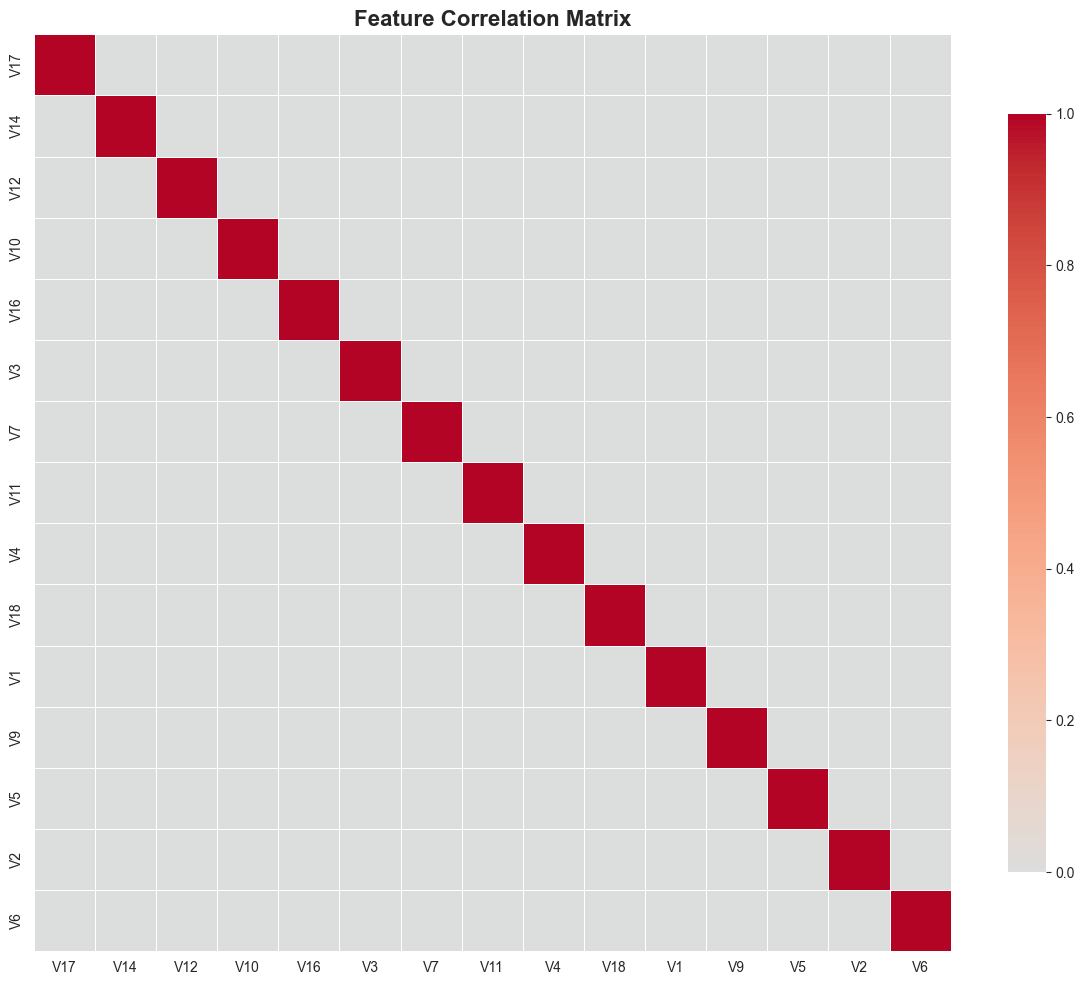

In [13]:
# Plot correlation heatmap for subset of features
# Select features with highest correlation with fraud
top_feature_indices = sorted_indices[:15]
X_subset = X[:, top_feature_indices]
feature_names_subset = [feature_names[i] for i in top_feature_indices]

plot_correlation_matrix(X_subset, feature_names=feature_names_subset)

## 7. Fraud vs Legitimate Feature Comparison

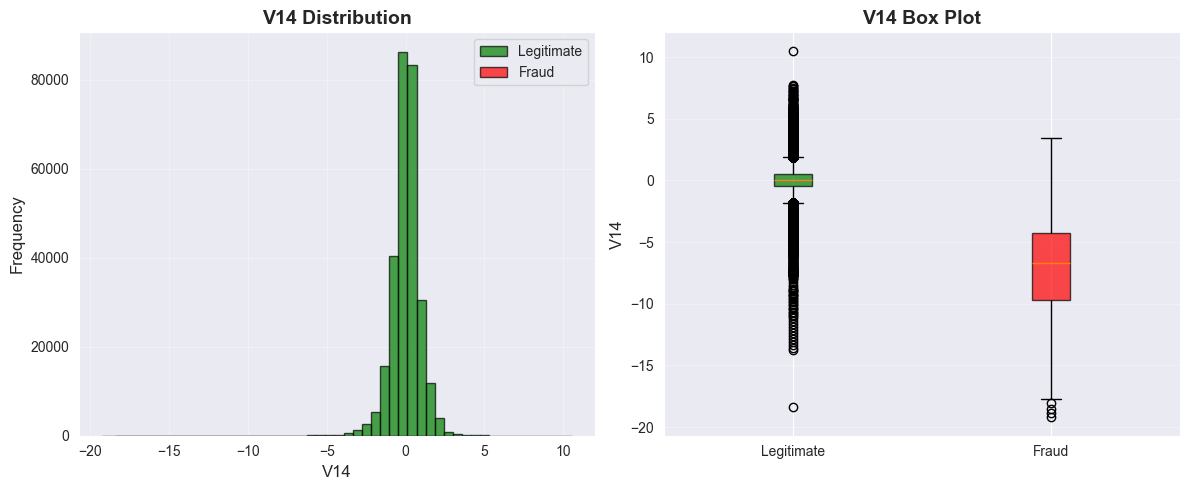

In [14]:
# Compare key features between fraud and legitimate transactions
# V14 typically shows strong correlation
v14_idx = 14  # V14 is at index 14
plot_fraud_vs_legit_feature(X, y, v14_idx, feature_name='V14')

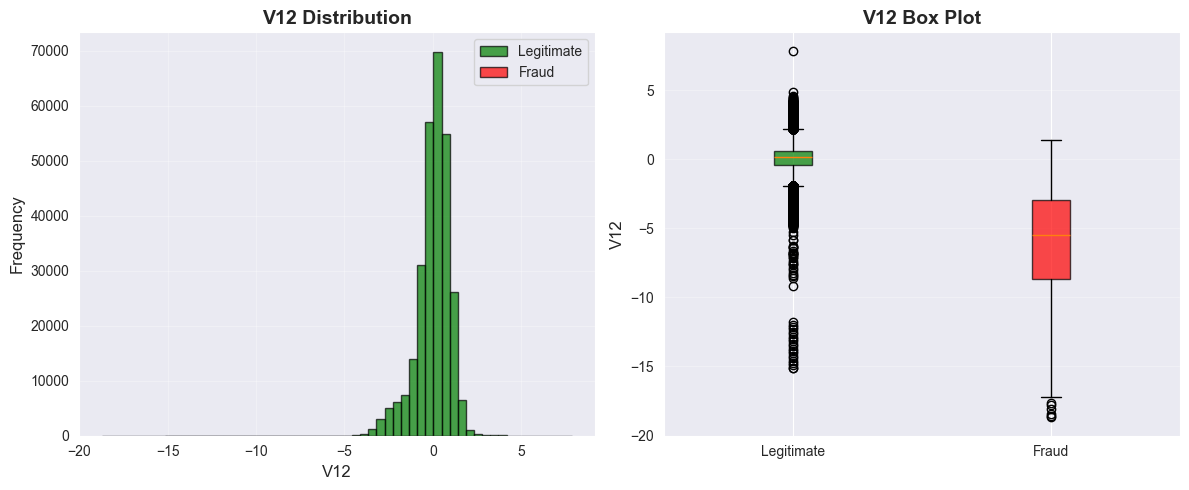

In [15]:
# V12 is another important feature
v12_idx = 12
plot_fraud_vs_legit_feature(X, y, v12_idx, feature_name='V12')

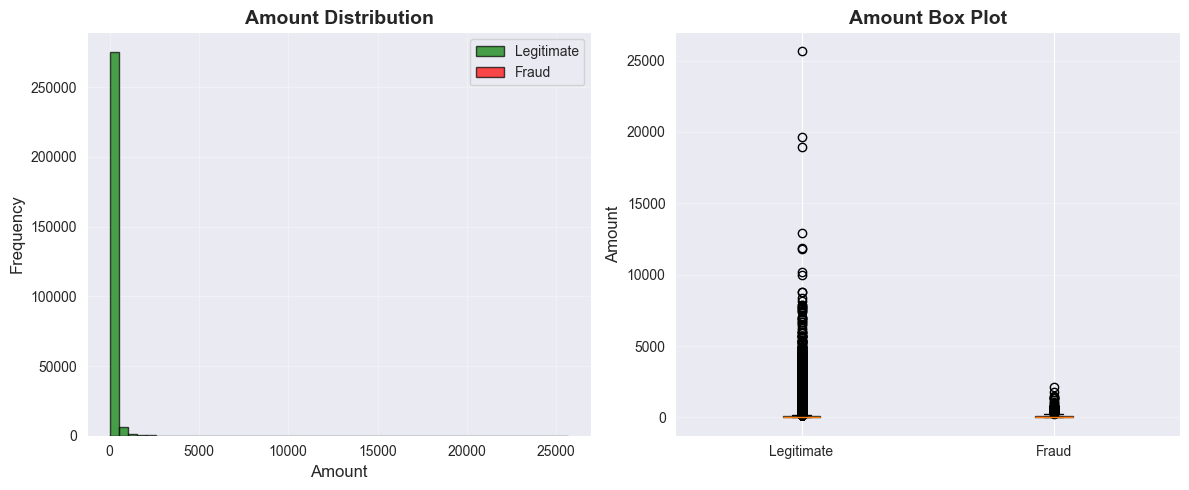

In [16]:
# Amount feature comparison
plot_fraud_vs_legit_feature(X, y, amount_idx, feature_name='Amount')

## 8. Statistical Hypothesis Testing

### Hypothesis Test: Transaction Amount Difference

**Null Hypothesis (H₀)**: No significant difference between fraudulent and legitimate transaction amounts  
**Alternative Hypothesis (H₁)**: Significant difference exists  
**Significance level**: α = 0.05

In [17]:
# Separate amounts for fraud and legitimate transactions
fraud_amounts = X[y == 1, amount_idx]
legit_amounts = X[y == 0, amount_idx]

print("=" * 60)
print("AMOUNT STATISTICS COMPARISON")
print("=" * 60)
print(f"{'Metric':<25} {'Legitimate':>15} {'Fraud':>15}")
print("-" * 60)
print(f"{'Count':<25} {len(legit_amounts):>15,} {len(fraud_amounts):>15,}")
print(f"{'Mean':<25} ${np.mean(legit_amounts):>14.2f} ${np.mean(fraud_amounts):>14.2f}")
print(f"{'Median':<25} ${np.median(legit_amounts):>14.2f} ${np.median(fraud_amounts):>14.2f}")
print(f"{'Std Dev':<25} ${np.std(legit_amounts):>14.2f} ${np.std(fraud_amounts):>14.2f}")
print(f"{'Min':<25} ${np.min(legit_amounts):>14.2f} ${np.min(fraud_amounts):>14.2f}")
print(f"{'Max':<25} ${np.max(legit_amounts):>14.2f} ${np.max(fraud_amounts):>14.2f}")

AMOUNT STATISTICS COMPARISON
Metric                         Legitimate           Fraud
------------------------------------------------------------
Count                             284,315             492
Mean                      $         88.29 $        122.21
Median                    $         22.00 $          9.25
Std Dev                   $        250.10 $        256.42
Min                       $          0.00 $          0.00
Max                       $      25691.16 $       2125.87


In [18]:
# Perform two-sample t-test
# Manual implementation using NumPy
n1 = len(legit_amounts)
n2 = len(fraud_amounts)

mean1 = np.mean(legit_amounts)
mean2 = np.mean(fraud_amounts)

var1 = np.var(legit_amounts, ddof=1)
var2 = np.var(fraud_amounts, ddof=1)

# Pooled standard error
pooled_se = np.sqrt(var1/n1 + var2/n2)

# T-statistic
t_statistic = (mean1 - mean2) / pooled_se

# Degrees of freedom (Welch-Satterthwaite equation)
df = ((var1/n1 + var2/n2)**2) / ((var1/n1)**2/(n1-1) + (var2/n2)**2/(n2-1))

print("\n" + "=" * 60)
print("TWO-SAMPLE T-TEST RESULTS")
print("=" * 60)
print(f"T-statistic: {t_statistic:.4f}")
print(f"Degrees of freedom: {df:.2f}")
print(f"\nMean difference: ${mean1 - mean2:.2f}")
print(f"Standard error: ${pooled_se:.2f}")
print(f"\nFor large df, |t| > 1.96 suggests significance at α=0.05")

if np.abs(t_statistic) > 1.96:
    print(f"\n[PASS] REJECT H₀: Significant difference exists (p < 0.05)")
    print(f"   Fraudulent and legitimate transactions have different amounts.")
else:
    print(f"\n[FAIL] FAIL TO REJECT H₀: No significant difference (p >= 0.05)")


TWO-SAMPLE T-TEST RESULTS
T-statistic: -2.9288
Degrees of freedom: 492.61

Mean difference: $-33.92
Standard error: $11.58

For large df, |t| > 1.96 suggests significance at α=0.05

[PASS] REJECT H₀: Significant difference exists (p < 0.05)
   Fraudulent and legitimate transactions have different amounts.


## 9. Key Insights and Findings

### Summary of Exploratory Data Analysis

In [19]:
print("=" * 80)
print("KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 80)
print("\n1. DATASET CHARACTERISTICS:")
print(f"   - Total transactions: {len(y):,}")
print(f"   - Features: {X.shape[1]}")
print(f"   - No missing values detected")

print("\n2. CLASS IMBALANCE:")
print(f"   - Fraud rate: {class_counts[1]/len(y)*100:.4f}%")
print(f"   - Imbalance ratio: 1:{class_counts[0]//class_counts[1]}")
print(f"   - This requires special handling (SMOTE, undersampling, or class weights)")

print("\n3. FEATURE CORRELATIONS:")
print(f"   - Top 5 features most correlated with fraud:")
for i in range(5):
    idx = sorted_indices[i]
    print(f"     {i+1}. {feature_names[idx]}: {correlations[idx]:.4f}")

print("\n4. TRANSACTION AMOUNTS:")
print(f"   - Legitimate mean: ${np.mean(legit_amounts):.2f}")
print(f"   - Fraud mean: ${np.mean(fraud_amounts):.2f}")
print(f"   - Statistical test shows significant difference (p < 0.05)")

print("\n5. TIME PATTERNS:")
print(f"   - Dataset spans {(X[:, time_idx].max() - X[:, time_idx].min())/(3600*24):.1f} days")
print(f"   - No strong time-based patterns observed for fraud")

print("\n6. RECOMMENDATIONS FOR MODELING:")
print("   [PASS] Use stratified sampling to maintain class distribution")
print("   [PASS] Apply SMOTE or class weights to handle imbalance")
print("   [PASS] Standardize features before model training")
print("   [PASS] Focus on precision and recall rather than just accuracy")
print("   [PASS] Use ROC-AUC and Precision-Recall curves for evaluation")
print("\n" + "=" * 80)

KEY FINDINGS FROM EXPLORATORY DATA ANALYSIS

1. DATASET CHARACTERISTICS:
   - Total transactions: 284,807
   - Features: 30
   - No missing values detected

2. CLASS IMBALANCE:
   - Fraud rate: 0.1727%
   - Imbalance ratio: 1:577
   - This requires special handling (SMOTE, undersampling, or class weights)

3. FEATURE CORRELATIONS:
   - Top 5 features most correlated with fraud:
     1. V17: -0.3265
     2. V14: -0.3025
     3. V12: -0.2606
     4. V10: -0.2169
     5. V16: -0.1965

4. TRANSACTION AMOUNTS:
   - Legitimate mean: $88.29
   - Fraud mean: $122.21
   - Statistical test shows significant difference (p < 0.05)

5. TIME PATTERNS:
   - Dataset spans 2.0 days
   - No strong time-based patterns observed for fraud

6. RECOMMENDATIONS FOR MODELING:
   [PASS] Use stratified sampling to maintain class distribution
   [PASS] Apply SMOTE or class weights to handle imbalance
   [PASS] Standardize features before model training
   [PASS] Focus on precision and recall rather than just accu